# GMM in PCA space of ensemble of reanalysis datasets

In [1]:
import os
from importlib import reload
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy as ctp
import seaborn as sns
from sklearn import mixture, decomposition

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../../paper.mplstyle")

## Load data

In [2]:
path = "../../data/cmip6/historical/CESM2"
normalization = 'zscore'

ensemble_list = []
for folder_name in os.listdir(path)[0:20]:
    full_path = os.path.join(path, folder_name)
    if os.path.isdir(full_path):
        print(f'Load data in folder: {folder_name}')
        forcing, inityear, member = folder_name.split("_")
        fname = os.path.join(full_path, f'b.e21.BHIST{forcing}.f09_g17.LE2-{inityear}.{member}.ssta_lat-31_33_lon130_290_gr1.0.nc')
        buff = xr.open_dataset(fname)
        buff = buff.assign_coords(member=('time', [folder_name]*len(buff.time)))
        ensemble_list.append(buff)
print("Merge members!")
ds = xr.concat(ensemble_list, dim='time')
ds['lon'] = preproc.get_antimeridian_coord(preproc.lon_to_180(ds['lon']))


# Normalization
if normalization is not None:
    print("Normalize data!")
    attributes = {}
    ds_norm = []
    for var in list(ds.data_vars):
        scaler = preproc.Normalizer(method=normalization)
        buff = scaler.fit_transform(ds[var])
        buff.attrs = {'normalizer': scaler}
        ds_norm.append(buff)

    ds = xr.merge(ds_norm) 


Load data in folder: smbb_1301_014
Load data in folder: cmip6_1281_005
Load data in folder: smbb_1231_017
Load data in folder: cmip6_1251_004
Load data in folder: cmip6_1181_010
Load data in folder: cmip6_1251_006
Load data in folder: cmip6_1251_007
Load data in folder: cmip6_1301_004
Load data in folder: smbb_1281_017
Load data in folder: smbb_1251_016
Load data in folder: smbb_1301_020
Load data in folder: smbb_1281_014
Load data in folder: cmip6_1281_004
Load data in folder: smbb_1071_004
Load data in folder: cmip6_1101_006
Load data in folder: smbb_1231_015
Load data in folder: cmip6_1231_003
Load data in folder: cmip6_1231_009
Load data in folder: smbb_1301_017
Load data in folder: smbb_1231_014
Merge members!
Normalize data!


### EOF transformation

In [3]:
pcgmm_storer = {}
eof_projections = ["reanalysis", "CESM2-LENS"]
n_components = 2

# Load reanalysis data
datafile = "../../data/reanalysis/monthly/ssta_merged_dataset_1.nc"
ds_reanalysis = xr.open_dataset(datafile)
# Get common land sea mask from model
mask1 = ds['ssta'].isel(time=0).isnull()
mask2 = ds_reanalysis['ssta'].isel(time=0).isnull()
merged_mask = np.logical_or(mask1, mask2)

ds = ds.where(~merged_mask, other=np.nan)
ds_reanalysis = ds_reanalysis.where(~merged_mask, other=np.nan)

for projection in eof_projections:
    print(f"Projection: {projection}")
    if projection == "reanalysis":
        ds4eof = ds_reanalysis.where(~merged_mask, other=np.nan)

        # Normalization
        if normalization is not None:
            attributes = {}
            ds_norm = []
            for var in list(ds4eof.data_vars):
                scaler = preproc.Normalizer(method=normalization)
                buff = scaler.fit_transform(ds4eof[var])
                buff.attrs = {'normalizer': scaler}
                ds_norm.append(buff)

            ds4eof = xr.merge(ds_norm) 
    elif projection == "CESM2-LENS":
        ds4eof = ds.sel(lat=slice(-10,10))
    else:
        raise ValueError("Invalid projection")

    sppca = eof.SpatioTemporalPCA(ds4eof, n_components=n_components)
    print(f"Explained variance: {np.sum(sppca.explained_variance())}")
    if projection in ["CESM2-LENS", "CESM2-LENS (short)"]:
        sppca.pca.components_[0,:] = -sppca.pca.components_[0,:]
    
    eofs = sppca.get_eofs()
    # Save EOFs and PCs
    pcgmm_storer[projection] = dict(
        sppca=sppca,
        eofs=eofs,
    )


Projection: reanalysis
Explained variance: 0.4858709557113714
Projection: CESM2-LENS
Explained variance: 0.8104214347222173


### Get ENSO events

In [4]:
reload(utenso)
month_range=[12, 2]

for projection in eof_projections:
    print(projection) 
    if projection == "CESM2-LENS":
        x_enso, x_events = utenso.select_enso_events(ds.sel(lat=slice(-10,10)), month_range=month_range, threshold=0.5)
    else:
        x_enso, x_events = utenso.select_enso_events(ds, month_range=month_range, threshold=0.5)
    sppca = pcgmm_storer[projection]['sppca']
    pcgmm_storer[projection]['z_enso'] = xr.DataArray(
        data=sppca.transform(x_enso),
        coords={'time': x_enso['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
    ).assign_coords(member=('time', x_enso['member'].data))
    pcgmm_storer[projection]['z_events'] = xr.DataArray(
        data=sppca.transform(x_events),
        coords={'time': x_events['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
    ).assign_coords(member=('time', x_events['member'].data))

reanalysis
CESM2-LENS


Add CESM2-LENS with same lenght as reanalysis.

In [5]:
x_enso, x_events = utenso.select_enso_events(ds_reanalysis, month_range=month_range, threshold=0.5)
n_months_reanalysis = len(x_enso['time'])
n_events_reanalysis = len(x_events['time'])
pcgmm_storer['CESM2-LENS (short)'] = pcgmm_storer['CESM2-LENS'].copy()
pcgmm_storer['CESM2-LENS (short)']['z_enso'] = pcgmm_storer['CESM2-LENS']['z_enso'].isel(time=slice(0, n_months_reanalysis))
pcgmm_storer['CESM2-LENS (short)']['z_events'] = pcgmm_storer['CESM2-LENS']['z_events'].isel(time=slice(0, n_events_reanalysis))
eof_projections.append('CESM2-LENS (short)')

### GMM scan

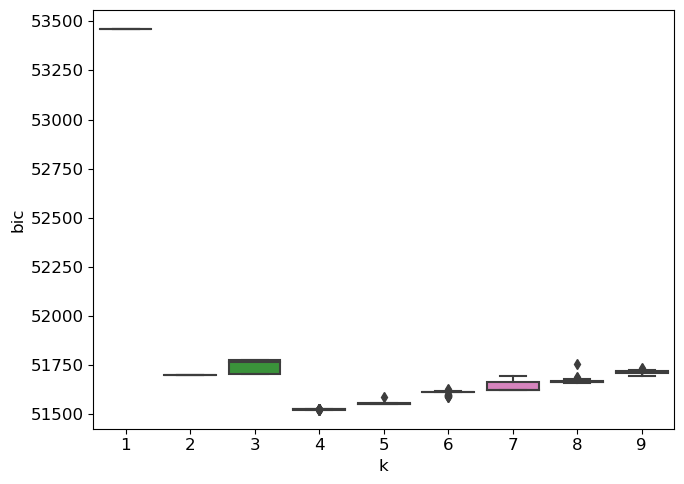

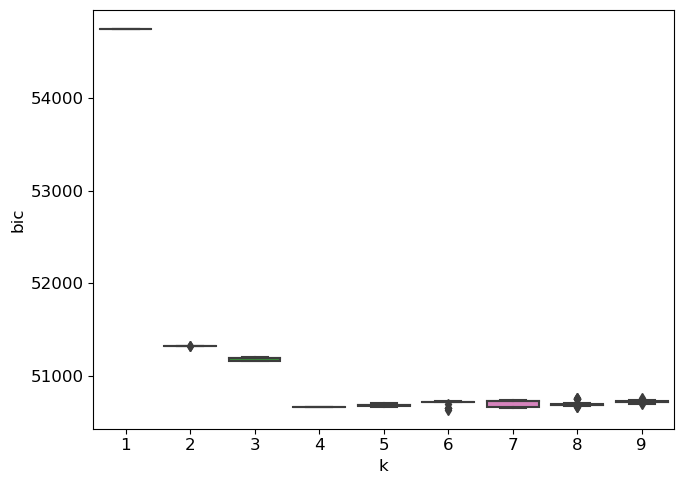

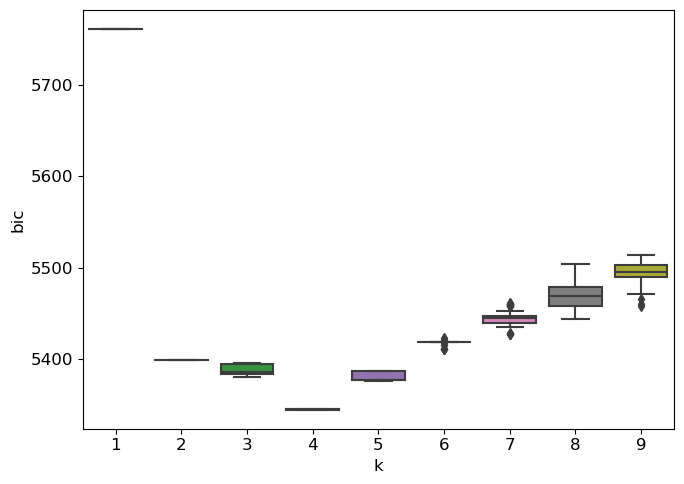

In [6]:
def bic(gmm, X, n_additional_parameters=0):
    """ Bayesian Information Criterion for GMMs including additional parameters.

    Args: 
        gmm (sklearn.mixture.GaussianMixture): The GMM to compute the BIC for.
        X (np.ndarray): The input samples of shape (n_samples, n_dimensions).
    
    Returns:
        bic (float) : The lower the better.
    """
    n_parameters = gmm._n_parameters() + n_additional_parameters
    return -2 * gmm.score(X) * X.shape[0] + n_parameters * np.log(X.shape[0])

n_classes = np.arange(1, 10, 1)
n_runs = 50
for projection in eof_projections:
    z_enso = pcgmm_storer[projection]['z_enso']
    result = []
    for k in n_classes:
        for r in range(n_runs):
            gmm = mixture.GaussianMixture(n_components=k, 
                                          covariance_type='full', max_iter=100)
            gmm.fit(z_enso.data)
            result.append(
                {'k': k, 'bic': bic(gmm, z_enso.data, n_components), 'gmm': gmm}
            )
    pcgmm_storer[projection]['gmm_scan'] = pd.DataFrame(result)

    fig, ax = plt.subplots()
    ax = sns.boxplot(data=pcgmm_storer[projection]['gmm_scan'], x='k', y='bic', ax=ax)

### Final plot

In [7]:
def plot_gaussians(gmm, ax, gmm_order=None, 
                   gmclrs=['maroon', 'darkorange', 'gold', 'lightblue', 'darkblue', 'black'],
                   alpha=0.5):
    """ Plot the Gaussian components of a Gaussian Mixture Model.
    """
    if gmm_order is None:
        gmm_order = np.arange(gmm.n_components)

    for i, k in enumerate(gmm_order):
        mean = gmm.means_[k, :]
        if gmm.covariance_type == "full":
            Sigma = gmm.covariances_[k, :]
        elif gmm.covariance_type == "diag":
            Sigma = np.diag(gmm.covariances_[k, :])

        gmkwargs= dict(fill=False)
        if gmclrs is not None:
            gmkwargs['edgecolor'] = 'k' #gmclrs[i] 
            gmkwargs['facecolor'] = gmclrs[i] 
            gmkwargs['fill'] = True
            gmkwargs['alpha'] = alpha

        for p in [0.9, 0.5, 0.1]:
            if p==0.1:
                gmkwargs['label'] = rf"$c_{k+1}$"
            gpl.plot_2dgaussian(mean, Sigma,
                                 ax=ax, p=p, **gmkwargs)
    return ax


/tmp/ipykernel_34567/1768376353.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../output/plots/pcgmm_cesm2_historical.png", dpi=300, bbox_inches="tight")
/tmp/ipykernel_34567/1768376353.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../output/plots/pcgmm_cesm2_historical.png", dpi=300, bbox_inches="tight")
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


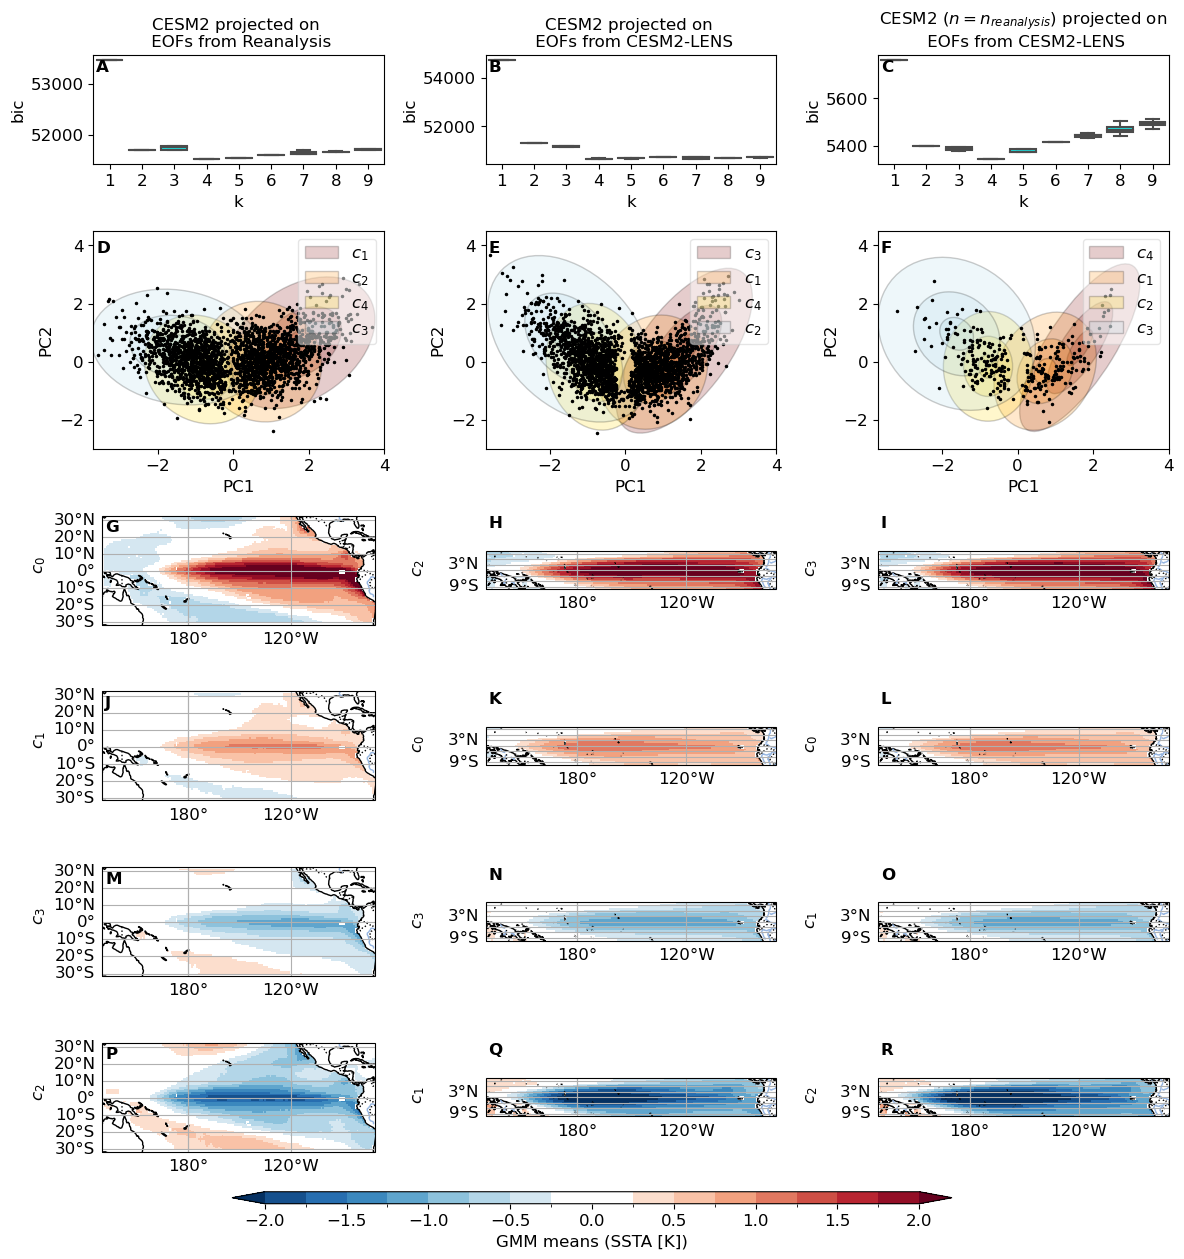

In [8]:
n_clusters = np.max([
    storer['gmm_scan']['k'].unique()[np.argmin([storer['gmm_scan'].loc[storer['gmm_scan']['k']==k]['bic'].mean() for k in storer['gmm_scan']['k'].unique()])]
    for storer in pcgmm_storer.values()
])
nrows, ncols = (n_clusters+2, len(eof_projections))
axs = np.empty((nrows, ncols), dtype=object)
fig = plt.figure(figsize=(ncols*4, nrows*2.))
height_ratio = [1]*nrows
height_ratio[1] = 2
gs = gridspec.GridSpec(nrows, ncols,
                       height_ratios=height_ratio)

proj = ctp.crs.PlateCarree(central_longitude=180)
plparam = {'ssta': dict(vmin=-2, vmax=2, step=0.25, cmap='RdBu_r', centercolor="#ffffff"),
           'ssha': dict(vmin=-.15, vmax=.15, step=0.025,cmap='RdGy_r', centercolor="#ffffff")}
titles = {
    'reanalysis': 'CESM2 projected on \n EOFs from Reanalysis',
    'CESM2-LENS': 'CESM2 projected on \n EOFs from CESM2-LENS',
    'CESM2-LENS (short)': (r'CESM2 ($n=n_{reanalysis}$) projected on' + '\n EOFs from CESM2-LENS'),
}

for i, projection in enumerate(eof_projections):
    storer = pcgmm_storer[projection]
    ## Plot EOFs
    #for n in range(n_components):
    #    ax = fig.add_subplot(gs[n,i], projection=proj)
    #    axs[n,i] = ax
    #    eof_map =  storer['eofs'].isel(eof=n)
    #    im = gpl.plot_map(eof_map['ssta'], central_longitude=180, ax=ax,
    #                 bar='continuous', vmin=-.03, vmax=.03, add_bar=False)
    #    im['gl'].top_labels = False 
    #    ax.text(-0.2, 0.55, rf"EOF{n+1}", va='bottom', ha='center',
    #            rotation='vertical', rotation_mode='anchor',
    #            transform=ax.transAxes)
    
    # Plot BIC
    idx = 0 #n + 1  
    ax = fig.add_subplot(gs[idx,i])
    axs[idx,i] = ax
    ax = sns.boxplot(data=storer['gmm_scan'], x='k', y='bic', ax=ax,
                     color='cyan', fliersize=0.0)

    # Plot Latent Space
    idx = idx + 1
    ax = fig.add_subplot(gs[idx,i])
    axs[idx,i] = ax
    z_events = storer['z_events']
    ax.plot(z_events.isel(eof=0), z_events.isel(eof=1), '.', color='k', markersize=3)
    ax.set_ylabel('BIC')

    # Gaussians
    # ============================
    # n_rand = np.random.randint(0, 1000)
    # gmm = mixture.GaussianMixture(n_components=5, covariance_type='full', max_iter=100,
    #                               random_state=n_rand)
    # gmm.fit(storer['z_enso'].data)
    # =============================
    #gmm_scan = storer['gmm_scan']
    #gmm = gmm_scan.loc[gmm_scan['bic'].idxmin()]['gmm']
    # ============================
    gmm_scan = storer['gmm_scan']
    k_min = gmm_scan['k'].unique()[np.argmin([gmm_scan.loc[gmm_scan['k']==k]['bic'].mean() for k in gmm_scan['k'].unique()])]
    idx_min = gmm_scan.loc[gmm_scan['k']==k_min]['bic'].argmin()
    gmm = gmm_scan.loc[gmm_scan['k']==k_min].iloc[idx_min]['gmm']
    # ============================
    gmm_order = np.argsort(gmm.means_[:, 0])[::-1]
    gmclrs=['maroon', 'darkorange', 'gold', 'lightblue', 'darkblue', 'black', 'darkgreen', 'magenta']
    plot_gaussians(gmm, ax, gmm_order=gmm_order, gmclrs=gmclrs, alpha=0.2)
    ax.legend(loc=1)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_ylim(-3, 4.5)
    ax.set_xlim(-3.7, 4)

    # Plot GMM means
    means = storer['sppca'].inverse_transform(gmm.means_, newdim='mu')
    if 'normalizer' in ds['ssta'].attrs.keys():
        means = ds['ssta'].attrs['normalizer'].inverse_transform(means['ssta'])
    for n, k in enumerate(gmm_order):
        mu = means.sel(mu=k)
        idx = idx + 1
        ax = fig.add_subplot(gs[idx,i], projection=proj)
        axs[idx,i] = ax
        im = gpl.plot_map(mu, central_longitude=180, ax=ax, 
                          bar='discrete', add_bar=False, **plparam['ssta'])
        im['gl'].top_labels = False 

        ax.text(-0.2, 0.55, rf"$c_{k}$", va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes)

    # Title
    axs[0,i].set_title(titles[projection], size=12)
    

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -.01, 0.6, 0.01])
cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.7,
                    cax=cbar_ax, extend='both')
cbar.set_label(f"GMM means (SSTA [K])", size=12)
    
# Enumerate plots
pos_y = 0.85 * np.ones((nrows, ncols))
pos_y[1, :] = 0.9
pos_y[2:, 1], pos_y[2:, 2] = 1.6, 1.6
gpl.enumerate_subplots(axs.flatten(), pos_x=.01, pos_y=pos_y.flatten())

# Save figure
if True:
    plt.savefig("../../output/plots/pcgmm_cesm2_historical.png", dpi=300, bbox_inches="tight")
